In [1]:
import sys
import numpy as np
from IPython.core.display import display, HTML
sys.path.append('../')
from src.d06_reporting.sample_evaluation import SampleEvaluation
from src.d04_modeling.propositional_classifier import PropositionalClassifier, andClassifier, orClassifier

# Sample Evaluation

This notebook extends the content from the methodology notebook and uses de AALPI and FRL sample data provided by the SFUSD to evaluate the different tiebreakers.

## Metrics

We can evaluate the different methodologies for assigning the equity tiebreakers by comparing the number of focal and non-focal students that receive the equity tiebreaker. In particular, since this assignment problem is similar to a classification problem, we can borrow metrics that we generally use to evaluate and tune classification models. In particular, we can borrow two tools: the receiver operating characteristic (ROC) curve and the precision-recall curve. Both plots involve tracing how different classification metrics change when changing some threshold or parameter that directly affects the classification outcomes. The ROC curve plots the true positive rate (TPR) against the false positive rate (FPR), while the precision-recall curve, as the name suggests, plots the precision of the model against its recall ability.

To compute these metrics, we need to count, for each model, the true positives (TP), false positives (FP), true negatives (TN), and false negatives (FN). In our case a:
- TP is a focal student who got the tiebreaker,
- FP is a non-focal student who got the tiebreaker,
- TN is a non-focal student who did not get the tiebreaker,
- FN is a focal student who did not get the tiebreaker
We can determine these counts by looking at what blocks are getting the equity tiebreaker and the number of focal and non-focal students in each block.
 
We can compute the TPR, FPR, precision, and recall as

`TPR = recall = TP / (TP + FN)`

`FNR = FP / (FP + TN)`

`precision = TP / (TP + FP)`

With these definitions in mind, we have that:
- the TPR and recall are the proportion of focal students receiving the equity tiebreaker,
- the FPR is the proportion of non-focal students receiving the equity tiebreaker,
- and the precision is the proportion of students getting the equity tiebreaker who are focal

Therefore, we can use the ROC curve to analyze the trade-off between the proportion of non-focal students prioritized by the equity tiebreaker when we relax a threshold to reach more focal students. On the other hand, we can use the precision-recall curve to quantify the change in the proportion of the students prioritized by the equity tiebreaker that is focal when we relax a threshold to reach more focal students.

## Setup

In this case we are going to compare the performance of the proposed methodology (DSSG ET) to a Benchmark and the CTIP1 methodology. The proposed methodology considers redline and subsidized housing zones as eligibility criteria and the individual block requirement is a threshold for the proportion of focal students in the block. For this analysis we are going to consider the students who are both AALPI and FRL as focal students. The Benchmark methodology is an instance of the Naive Classifier targeted at our definition of focal students. We look at the results using both the K-5 (`frl_key='tk12'`) block data and the K-12 (`frl_key='tk5'`) block data. As an example, in the following figure we show a map with the proportion of focal students in each block with the K-5 data.

In [2]:
proposed_focal_group = 'Both'
positive_group = 'n%s' % proposed_focal_group
model_feature = 'pct%s' % proposed_focal_group

se = dict()
for frl_key in ['tk5', 'tk12']:
    eligibility_classifier = orClassifier(["Housing", "Redline"], binary_var=[0,1])
    propositional_model = andClassifier([model_feature], positive_group=positive_group, eligibility_classifier=eligibility_classifier, frl_key=frl_key)
    propositional_params = np.linspace(0.,1., 100)
    se[frl_key] = SampleEvaluation(frl_key=frl_key, propositional_model=propositional_model, propositional_params=propositional_params)

Loading Block FRL data...Adding African-American counts to FRL data...
1.0777
Loading Block Demographic data...0.1436
Loading Student Demographic data...2.7212
Loading Block FRL data...Adding African-American counts to FRL data...
0.5651
Loading Block Demographic data...0.1618
Loading Student Demographic data...1.2647
Propositional Statement:
pctBoth >=  {0:.2f}
Focal group: nBoth
Loading Block FRL data...0.0979
Loading Block Demographic data...0.1267
Loading Student Demographic data...0.9384
Propositional Statement:
pctBoth >=  {0:.2f}
Focal group: nBoth


Loading Block FRL data...0.1045
Loading Block Demographic data...0.1197
Loading Student Demographic data...0.8962


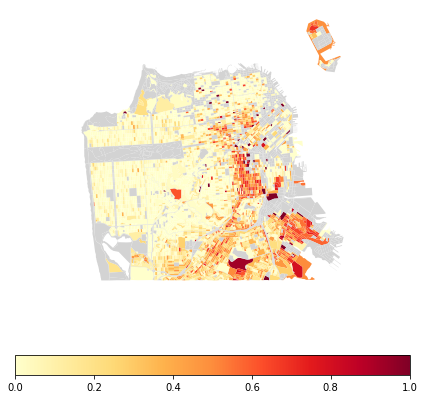

In [3]:
display(HTML("<h3>Figure 1: Geographic distribution of students</h3>"))
se['tk5'].heat_map1(column='pctBoth', pct_frl=True, legend=True)

## Results

## K-5

In the following plots, we show the ROC and precision-recall curves for the three methodologies. Since CTIP1 does not have a tuning parameter, we plot it as a single point in each figure. The CTIP1 has a 16% FPR for the K-5 data. We highlight this "operation point" in the ROC curve as a dashed black line. Since we calibrate the Benchmark model by specifying the FPR rate, we can recover the solution of this model directly. For the DSSG ET, we need a threshold for the proportion of focal students of each block. To get a 16% FPR for this model, we need to set this threshold to 31%. From both figures, we can see that the Benchmark methodology performs best, followed by the DSSG ET model and CTIP1.

CTIP1 FPR: 0.1596
Parameters DSSG ET @ 0.1596:
0.31313131313131315


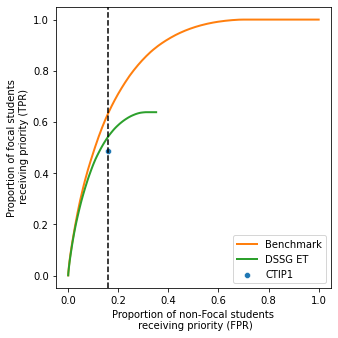

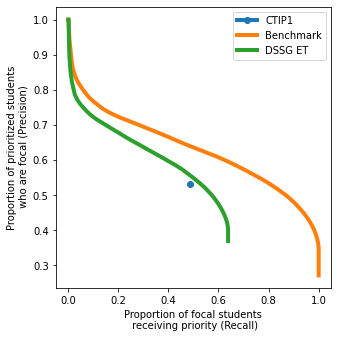

In [4]:
# Plot the ROC curves for different models for the TK12 FRL and AALPI data and the proposition:
frl_key = 'tk5'
fpr = se[frl_key].get_ctip1_fpr()
params = se[frl_key].get_dssg_et_params(fpr)
display(HTML("<h3>Figure 2: ROC curve</h3>"))
se[frl_key].classifier_evalutaion_roc(x=fpr)
display(HTML("<h3>Figure 3: Precision-recall curve</h3>"))
se[frl_key].classifier_evalutaion_precision_recall()

Given the sensitive context of the equity tiebreaker and the goal to target historically underserved communities, it is also vital to look at how the equity tiebreaker assignment looks on a map of the SFUSD. The following figures show the distribution of the equity tiebreaker for the three methodologies considering a 16% FPR. We highlight the blocks receiving priority in yellow.

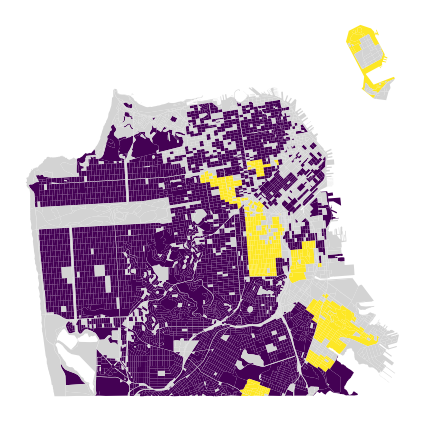

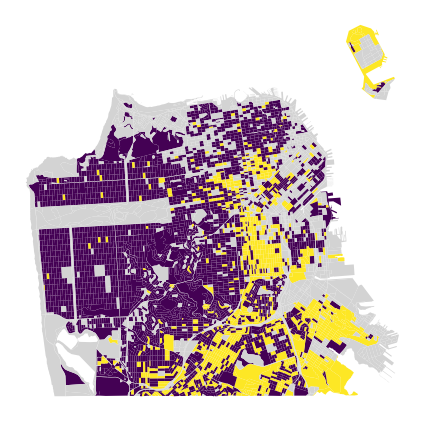

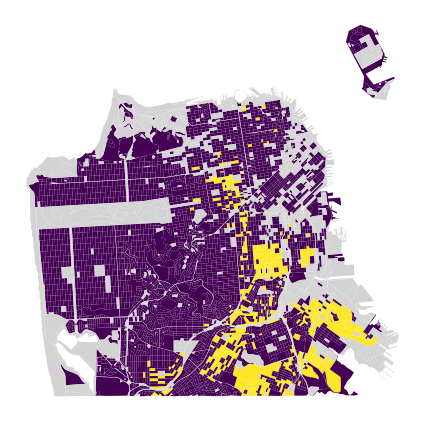

In [5]:
display(HTML("<h3>Figure 4: Equity tiebreaker map for a 16% FPR</h3>"))
se[frl_key].classification_map(fpr=fpr, params=params)

These maps do a great job of showing some of the advantages and limitations of each method. The CTIP1, by design, targets a small number of large zones. This grouping of blocks limits the selectivity but allows for a more cohesive and intuitive distribution of the equity tiebreaker. Intuitive in the sense of how easily we can explain which areas get the tiebreaker. 

On the other hand, the Benchmark tiebreaker optimizes at a block-level which areas receive the equity tiebreaker. This optimization yields a more granular and spread-out distribution that is harder to explain. Also, some of the blocks lie outside of historically underserved areas. The blocks in the northwestern part of the city are examples of this phenomenon. Although these blocks have a high concentration of focal students, they lie in zones with enough resources to adequately serve all of their students.  

Finally, the DSSG Equity Tiebreaker seems to be a middle point between these two tiebreakers. The eligibility requirements enforce certain geographical coherence and help focus the tiebreaker on historically underserved zones in the southeastern part of the city.  However, unlike the CTIP1 tiebreaker, the proposed methodology still allows some level of optimization and granularity in the block selection.

## K-12

We can repeat the analysis for the K-12 data. If we look at the following figures, we can reach the same conclusions as in the previous section.

CTIP1 FPR: 0.1354
Parameters DSSG ET @ 0.1354:
0.393939393939394


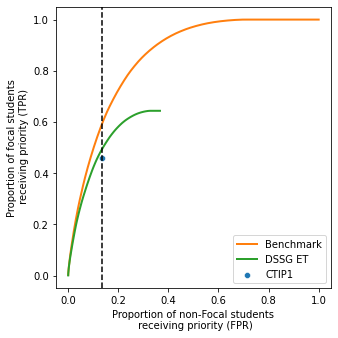

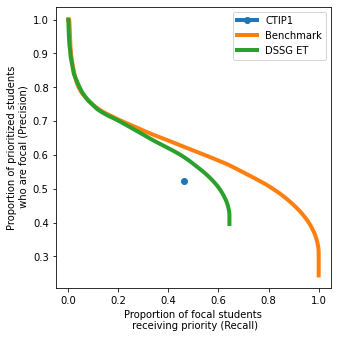

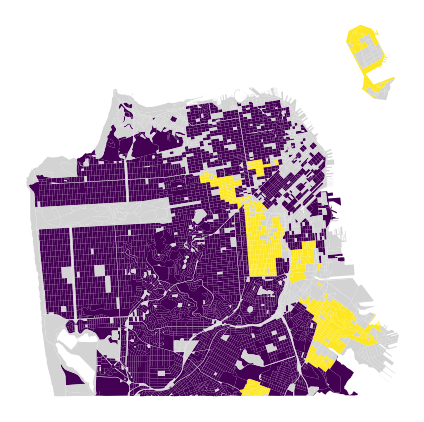

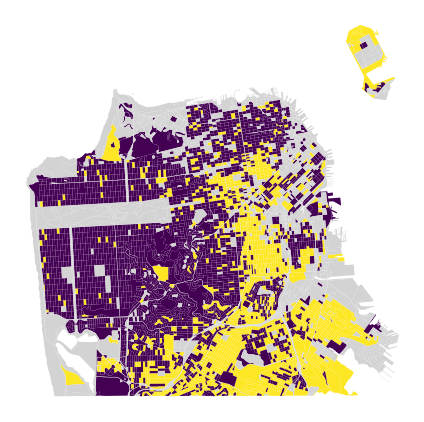

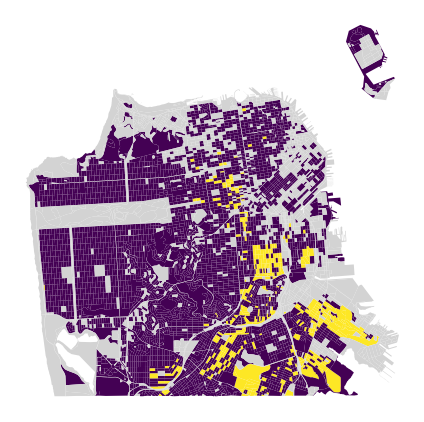

In [6]:
# Plot the ROC curves for different models for the TK12 FRL and AALPI data and the proposition:
frl_key = 'tk12'
fpr = se[frl_key].get_ctip1_fpr()
params = se[frl_key].get_dssg_et_params(fpr)
display(HTML("<h3>Figure 5: ROC curve</h3>"))
se[frl_key].classifier_evalutaion_roc(x=fpr)
display(HTML("<h3>Figure 6: Precision-recall curve</h3>"))
se[frl_key].classifier_evalutaion_precision_recall()
display(HTML("<h3>Figure 7: Equity tiebreaker map for a 16% FPR</h3>"))
se[frl_key].classification_map(fpr=fpr, params=params)